<a href="https://colab.research.google.com/github/mandliya/dailyLearning/blob/main/notebooks/MakeMore_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP model for Makemore

## Load the data

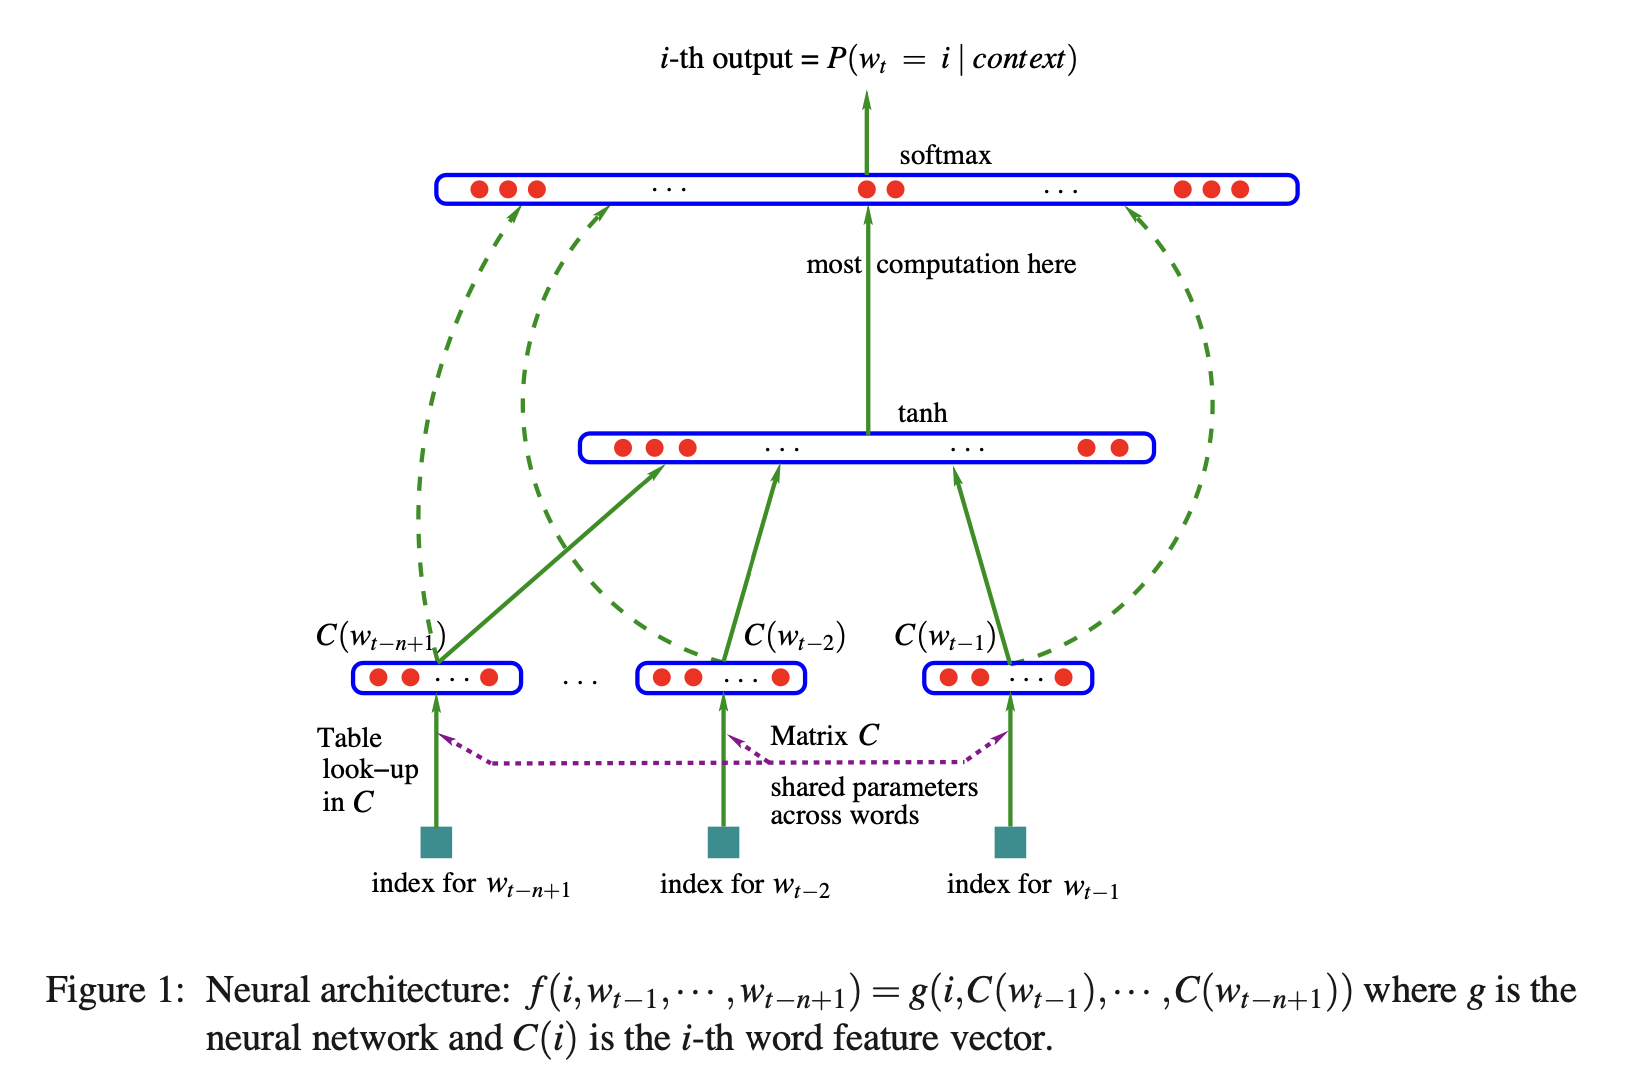

In [57]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [43]:
words = open('names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [123]:
block_size = 3
embedding_size = 2
hidden_layer_neurons = 100
total_chars = 27 # 26 + special token '.'
iterations = 10000
mini_batch_size = 64


## Create Indexes

In [45]:
# build index
chars = ['.'] + list(set([c for word in words for c in word]))
stoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for c,i in stoi.items()}

## Build the dataset

In [67]:
# build the dataset
X = []
y = []

for w in words:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    y.append(ix)
    context = context[1:] + [ix]
X = torch.tensor(X)
y = torch.tensor(y)

In [68]:
X.shape, X.dtype, y.shape, y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

## Context Mapping

In [69]:
C = torch.randn((total_chars, embedding_size))

In [70]:
# Get embeddings
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

## Hidden Layer

In [71]:
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn((block_size * embedding_size, hidden_layer_neurons), generator=g ,requires_grad=True)
b1 = torch.randn(hidden_layer_neurons, generator=g)

h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1)

In [72]:
h.shape

torch.Size([228146, 100])

## Output Layer

In [52]:
W2 = torch.randn((hidden_layer_neurons, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g)
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape

torch.Size([228146, 27])

## Loss Function

In [53]:
loss = -probs[torch.arange(X.shape[0]), y].log().mean()
loss

tensor(15.7376, grad_fn=<NegBackward0>)

We should use here pytorch's cross entropy loss, which is way more efficient at calculating the loss.
1. It doesn't create intermediate tensors (e.g. counts etc), hence way more optimized. Thus forward pass is way more efficient. The backpropagation is also very effective, as it uses simpler mathematical expressions. For example, instead of calculating tanh's gradient using exponential function, it can directly use `1-t^2`.
2. More numerically well behaved. For extreme values, the `counts` which is taking `exp` can lead to infinite value and thus lead to a `nan`. For example

In [54]:
logits_temp = torch.tensor([-100, -3, 0, 100])
counts_temp = logits_temp.exp()
counts_temp

tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

In [59]:
loss = F.cross_entropy(logits, y)

Putting it all together in one cell

In [118]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((total_chars, embedding_size), generator=g)
W1 = torch.randn((embedding_size * block_size, hidden_layer_neurons), generator=g)
b1 = torch.randn(hidden_layer_neurons, generator=g)
W2 = torch.randn((hidden_layer_neurons, total_chars), generator=g)
b2 = torch.randn(total_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

Set `requires_grad` on all params

In [119]:
for p in parameters:
  p.requires_grad = True

Set up learning rates.

In [120]:
lre = torch.linspace(-3, 0, iterations)
lrs = 10**lre

In [121]:
lrk = []
lossk = []
for k in range(1, iterations + 1):

  # mini batch
  ix = torch.randint(0, X.shape[0], (mini_batch_size,))

  # Forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, (embedding_size * block_size)) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y[ix])

  if k % 100 == 0:
    print(f'iteration: {k}: loss: {loss.item()}')

  # Zero grad
  for p in parameters:
    p.grad = None

  # Backward pass
  loss.backward()

  # update params
  lr = lrs[k-1]
  for p in parameters:
    p.data += -lr * p.grad
  
  #track stats
  lrk.append(lr)
  lossk.append(loss.item())
  


iteration: 100: loss: 14.848410606384277
iteration: 200: loss: 11.82883358001709
iteration: 300: loss: 10.84434700012207
iteration: 400: loss: 8.099961280822754
iteration: 500: loss: 3.9562604427337646
iteration: 600: loss: 3.863009452819824
iteration: 700: loss: 3.1496760845184326
iteration: 800: loss: 3.3083250522613525
iteration: 900: loss: 4.298625469207764
iteration: 1000: loss: 6.295966625213623


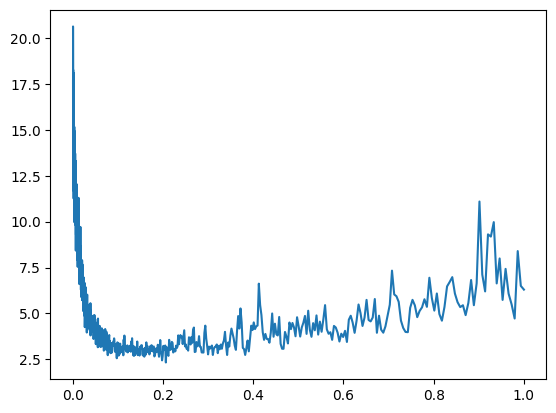

In [122]:
plt.plot(lrk, lossk)

lr=0.1 makes most sense. We can potentially choose 0.1 initially for last couple of thousand iterations we can use 0.01

In [126]:
block_size = 3
embedding_size = 2
hidden_layer_neurons = 100
total_chars = 27 # 26 + special token '.'
iterations = 10000
mini_batch_size = 32


g = torch.Generator().manual_seed(2147483647)
C = torch.randn((total_chars, embedding_size), generator=g)
W1 = torch.randn((embedding_size * block_size, hidden_layer_neurons), generator=g)
b1 = torch.randn(hidden_layer_neurons, generator=g)
W2 = torch.randn((hidden_layer_neurons, total_chars), generator=g)
b2 = torch.randn(total_chars, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

for k in range(1, iterations + 1):

  # mini batch
  ix = torch.randint(0, X.shape[0], (mini_batch_size,))

  # Forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, (embedding_size * block_size)) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y[ix])

  if k % 1000 == 0:
    print(f'iteration: {k}: loss: {loss.item()}')

  # Zero grad
  for p in parameters:
    p.grad = None

  # Backward pass
  loss.backward()

  # update params
  lr = 0.1 if k < 8000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  

print(f'Loss: {loss.item()}')

iteration: 1000: loss: 2.521613121032715
iteration: 2000: loss: 2.586514949798584
iteration: 3000: loss: 3.0184381008148193
iteration: 4000: loss: 2.620488166809082
iteration: 5000: loss: 2.7561018466949463
iteration: 6000: loss: 2.5160071849823
iteration: 7000: loss: 2.461977243423462
iteration: 8000: loss: 2.259788990020752
iteration: 9000: loss: 2.5085067749023438
iteration: 10000: loss: 2.2321643829345703
Loss: 2.2321643829345703


As Andrej pointed out, we should be doing this proper train, dev and test validation set. So let's do that.

We will also try some hyperparams to see if we can improve the model.

In [142]:
block_size = 3
embedding_size = 10
hidden_layer_neurons = 250
total_chars = 27 # 26 + special token '.'
iterations = 200000
mini_batch_size = 32

In [143]:
def build_dataset(words):
  X = []
  y = []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  y = torch.tensor(y)
  return X, y



In [144]:
import random
random.seed(2147483647)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [145]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((total_chars, embedding_size), generator=g)
W1 = torch.randn((embedding_size * block_size, hidden_layer_neurons), generator=g)
b1 = torch.randn(hidden_layer_neurons, generator=g)
W2 = torch.randn((hidden_layer_neurons, total_chars), generator=g)
b2 = torch.randn(total_chars, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

stepk = []
lossk = []
for k in range(1, iterations + 1):

  # mini batch
  ix = torch.randint(0, X.shape[0], (mini_batch_size,))

  # Forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, (embedding_size * block_size)) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y[ix])

  if k % 50000 == 0:
    print(f'iteration: {k}: loss: {loss.item()}')

  # Zero grad
  for p in parameters:
    p.grad = None

  # Backward pass
  loss.backward()

  # update params
  lr = 0.1 if k < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  #update stats
  stepk.append(k)
  lossk.append(loss.log10().item())

print(f'Training Loss: {loss.item()}')

iteration: 50000: loss: 2.2306253910064697
iteration: 100000: loss: 2.34765362739563
iteration: 150000: loss: 2.0148580074310303
iteration: 200000: loss: 2.1367170810699463
Training Loss: 2.1367170810699463


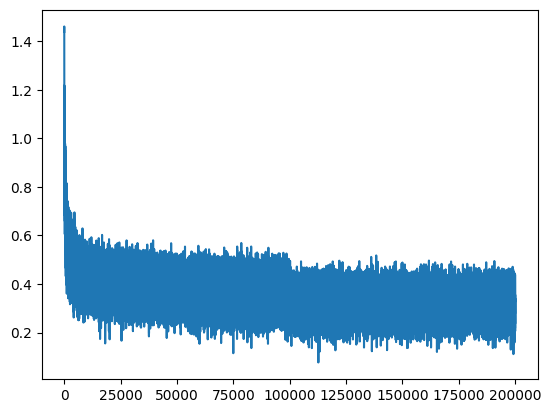

In [146]:
plt.plot(stepk, lossk)

Let's calculate the loss over entire training set

In [147]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, (embedding_size * block_size)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1184, grad_fn=<NllLossBackward0>)

Let's see what happens on dev set

In [148]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, (embedding_size * block_size)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1172, grad_fn=<NllLossBackward0>)